<a href="https://colab.research.google.com/github/Stelath/pytorch-learning/blob/main/Pytorch_Learning_8_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Dataset

In [ ]:
!wget -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

Import Librarys

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

Import Dataset

In [ ]:
REBUILD_DATA = True

class DogsVSCats():
  IMG_SIZE = 50
  CATS = 'PetImages/Cat'
  DOGS = 'PetImages/Dog'
  LABELS = {CATS: 0, DOGS: 1}
  training_data = []
  cat_count = 0
  dog_count = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          if label == self.CATS:
            self.cat_count += 1
          elif label == self.DOGS:
            self.dog_count += 1
        except Exception as e:
          pass
          # print(str(e))
    
    np.random.shuffle(self.training_data)
    np.save('training_data.npy', self.training_data)
    print()
    print('Cats:', self.cat_count)
    print('Dogs:', self.dog_count)

if REBUILD_DATA:
  dogvcats = DogsVSCats()
  dogvcats.make_training_data()


PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 830.88it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:15<00:00, 794.64it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



Cats: 12476
Dogs: 12470


In [ ]:
training_data = np.load('training_data.npy', allow_pickle=True)
print(len(training_data))
print(training_data[0])

24946
[array([[25, 25, 25, ...,  1, 13, 16],
       [25, 25, 25, ..., 10, 11,  2],
       [25, 25, 25, ...,  8, 23,  4],
       ...,
       [19, 20, 22, ..., 15, 16, 16],
       [22, 22, 22, ..., 17, 13, 14],
       [20, 23, 22, ..., 17, 16, 16]], dtype=uint8)
 array([1., 0.])]


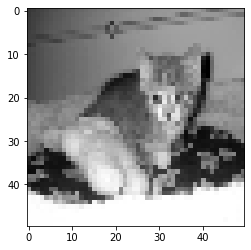

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(training_data[2][0], cmap='gray')
plt.show()

In [ ]:
training_data[2][1]

array([1., 0.])

Build Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
    
    if self._to_linear is None:
      self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    # Use activation function cause its probably better
    return F.softmax(x, dim = 1)


CUDA

In [ ]:
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

# Create the neural net
net = Net().to(device)

CUDA Available: True
Running on the GPU


Optimization

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

### Training & Testing

In [ ]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 # Scale imagery so pixle values are between 0 and 1 not 0 and 255
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

2494
22452
2494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [ ]:
# Set train default to false so that you don't accidentally train on your validation data
# IE. your gonna notice way faster if your model isnt training than if you accidentally passed eval data
def fwd_pass(X, y, train=False):
  X = X.to(device)
  y = y.to(device)

  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True) / len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  
  return acc, loss


In [ ]:
def test(size=32):
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start + size], test_y[random_start:random_start + size] # Not sure about this, might be better to shuffle the array
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
  return val_acc, val_loss


In [ ]:
import time

MODEL_NAME = f'model-{int(time.time())}'
net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(EPOCHS=8, BATCH_SIZE=64):
  with open('model.log', 'a') as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i + BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i % BATCH_SIZE == 0: # Every 64 steps calculate the accuracy
          val_acc, val_loss = test(size=32)
          f.write(f'{MODEL_NAME}, {round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)}, {round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n')

Training Model

In [ ]:
train(EPOCHS=20)

100%|██████████| 351/351 [00:08<00:00, 42.37it/s]


Test & Eval Model

In [ ]:
val_acc, val_loss = test(size=512)
print(f'Validation Accuracy: {val_acc}\nValidation Loss: {val_loss}')

Validation Accuracy: 0.732421875
Validation Loss: 0.21960507333278656
